# Compare CCL against benchmarks
This notebook performs comparisons of CCL against our benchmarks for different cosmological quantities. These plots are presented in the CCL paper. Benchmarks are documented in the CCL wiki: https://github.com/LSSTDESC/CCL/wiki/Benchmarks

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
%matplotlib inline

### Set up the benchmark cosmologies 
`Cosmology` objects contain the parameters and metadata needed as inputs to most functions. Each `Cosmology` object has a set of cosmological parameters attached to it. In this example, we will only use the parameters of a vanilla LCDM model, but simple extensions (like curvature, neutrino mass, and w0/wa) are also supported.

`Cosmology` objects also contain precomputed data (e.g. splines) to help speed-up certain calculations. As such, `Cosmology` objects are supposed to be immutable; you should create a new `Cosmology` object when you want to change the values of any cosmological parameters.

The cosmologies we are setting up at this stage are documented in the CCL paper, Table 2. With the following plots, we verify the level of accuracy stated in Table 3.

In [3]:
# Insert default CCL cosmology
ccl_cosmology = ccl.Cosmology(Omega_c=0.25,
                              Omega_b=0.05,
                              Omega_k=0.0,
                              h=0.7,
                              n_s=0.96,
                              sigma8=0.8)

print("Pure Omega_l from CCL: ", ccl_cosmology.params.parameters.Omega_l)
print("Pure Omega_g from CCL: ", ccl_cosmology.params.parameters.Omega_g)
print("Pure Omega_n_rel from CCL: ", ccl_cosmology.params.parameters.Omega_n_rel)
print("Combined: Omega_l + Omega_g + Omega_n_rel: ", ccl_cosmology.params.parameters.Omega_l
                                         + ccl_cosmology.params.parameters.Omega_g 
                                         + ccl_cosmology.params.parameters.Omega_n_rel)

Omega_l:  0.699932473308281
Omega_g:  5.04319404656203e-05
Omega_n_rel:  1.7094751253346745e-05
Omega_l + Omega_g + Omega_n_rel:  0.7


### The key thing that needs to be changed with the cosmology is that Omega_l should be redefined inside the CCL cosmology to be the same as in CCL/src/ccl_core.c (see the note above). For now we are proceeding to make the plots, but this is the main flag.

In [91]:
cosmo_ccl1 = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96)
cosmo_ccl2 = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9)
cosmo_ccl3 = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1)
cosmo_ccl4 = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, Omega_k=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1)
cosmo_ccl5 = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, Omega_k=-0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1)
cosmo_ccl6 = ccl.Cosmology(Omega_c=0.3, Omega_b=0.0, h=0.7, A_s = 2.1e-9, n_s=0.96)

cosmo_list=[cosmo_ccl1,cosmo_ccl2,cosmo_ccl3,cosmo_ccl4,cosmo_ccl5,cosmo_ccl6]
num_models=5
cosmo_list_hiz=[cosmo_ccl1,cosmo_ccl2,cosmo_ccl3]
num_models_hiz =3

### Cosmological Distances

With the cosmologies set up, we will not compute comoving radial distances and compare them to our input benchmark files. First, let's load the benchmark file. The format is: (z,d1,d2,d3,d4,d5) where z is the redshift, d are distances and 1-5 refers to the cosmologies set up above. The units are Mpc/h.

In [82]:
bench=np.loadtxt('../tests/benchmark/chi_model1-5.txt')
z=bench[1:,0]
d_bench=bench[1:,1:]
scale_fact=1./(1+z)

Now let's calculate CCL predictions to compare against the benchmark. Notice CCL returns quantities in units of Mpc.

In [83]:
d_ccl = np.zeros((len(z),num_models))
for i in range(num_models):
    d_ccl[:,i]=ccl.comoving_radial_distance(cosmo_list[i],scale_fact)*(cosmo_list[i])['h']

And we will now make a plot comparing the two quantities.

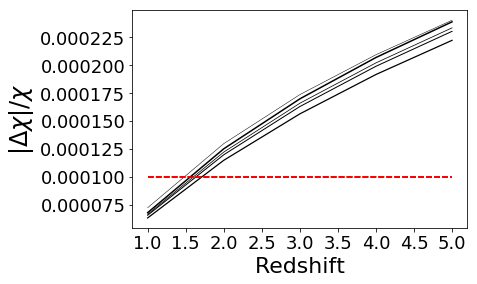

In [84]:
plt.figure()
plt.ylabel(r'$|\Delta\chi|/\chi$',fontsize=24)
plt.xlabel('Redshift',fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for i in range(0,5):
    plt.plot(z,np.abs(d_bench[:,i]/d_ccl[:,i]-1),'k-',lw=i*0.25+0.5)
    plt.plot(z, 1e-4*z/z, linestyle='--', color='r')
plt.show()
plt.clf()

### Cosmological distances (high z)

In [104]:
bench=np.loadtxt('../tests/benchmark/chi_hiz_model1-3.txt')
z=bench[1:,0]
d_hiz_bench=bench[1:,1:]
scale_fact=1./(1+z)
d_hiz_ccl = np.zeros((len(z),num_models_hiz))

for i in range(num_models_hiz):
    d_hiz_ccl[:,i]=ccl.comoving_radial_distance(cosmo_list_hiz[i],scale_fact)*(cosmo_list[i])['h']

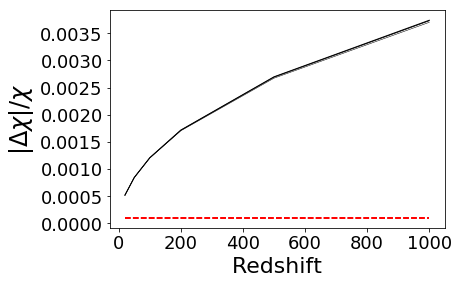

In [105]:
plt.figure()
plt.ylabel(r'$|\Delta\chi|/\chi$',fontsize=24)
plt.xlabel('Redshift',fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for i in range(0,num_models_hiz):
    plt.plot(z,np.abs(d_hiz_bench[:,i]/d_hiz_ccl[:,i]-1),'k-',lw=i*0.25+0.5)
    plt.plot(z, 1e-4*z/z, linestyle='--', color='r')
plt.show()
plt.clf()


### To-do: ensure all plots match the level of accuracy of Table 3.

### To-do: repeat the same exercise above test by test for all entries in Table 3. This can be done looking at the .c files in tests/

### Growth function (low z)

In [106]:
bench=np.loadtxt('../tests/benchmark/growth_model1-5.txt')
z=bench[0:,0]
g_bench=bench[0:,1:]
scale_fact=1./(1+z)
g_ccl = np.zeros((len(z),num_models))
for i in range(0,5):
    g_ccl[:,i]=ccl.growth_factor(cosmo_list[i],scale_fact)


/Users/reneehlozek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


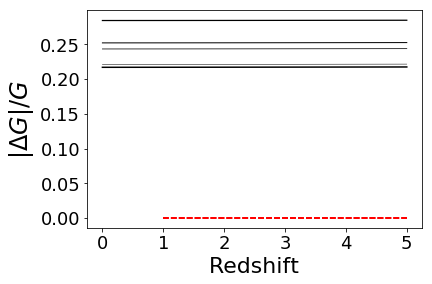

In [107]:
plt.figure()
plt.ylabel(r'$|\Delta G|/G$',fontsize=24)
plt.xlabel('Redshift',fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for i in range(0,5):
    plt.plot(z,np.abs(g_bench[:,i]/g_ccl[:,i]-1),'k-',lw=i*0.25+0.5)
    plt.plot(z, 1e-4*z/z, linestyle='--', color='r')
plt.show()
plt.clf()

### Growth function (high z)

In [109]:

bench=np.loadtxt('../tests/benchmark/growth_hiz_model1-3.txt')
z=bench[0:,0]
num_z = np.shape(bench)[0]
g_hiz_bench=bench[0:,1:]
scale_fact=1./(1+z)

In [110]:
g_hiz_ccl = np.zeros((num_z, num_models_hiz))
for i in range(num_models_hiz):
    g_hiz_ccl[:,i]=ccl.growth_factor(cosmo_list_hiz[i],scale_fact)

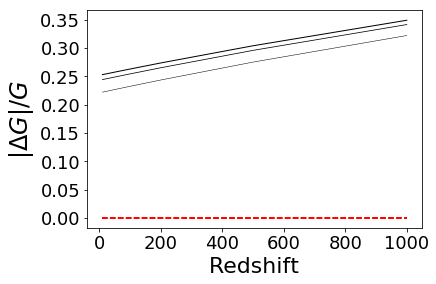

In [111]:
plt.figure()
plt.ylabel(r'$|\Delta G|/G$',fontsize=24)
plt.xlabel('Redshift',fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for i in range(num_models_hiz):
    plt.plot(z,np.abs(g_hiz_bench[:,i]/g_hiz_ccl[:,i]-1),'k-',lw=i*0.25+0.5)
    plt.plot(z, 1e-4*z/z, linestyle='--', color='r')
plt.show()
plt.clf()